In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm
import torch
from torch import nn

In [2]:
import os

In [3]:
from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise import KNNWithMeans


In [4]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import ndcg_score

In [5]:
import torch

from spotlight.factorization.explicit import ExplicitFactorizationModel
from spotlight.interactions import Interactions
from spotlight.evaluation import rmse_score


In [6]:
import optuna 
from scipy.sparse import coo_matrix, csr_matrix, lil_matrix, vstack, hstack
from scipy import sparse


In [7]:
def get_train(data, train_ind):
    
    train_data = data.loc[train_ind][data.columns[:3]]
    train_data = train_data.rename(columns={train_data.columns[1]: "item"})
    train_user = train_data.user.value_counts().index.to_numpy()
    train_user = np.sort(train_user)
    
    return train_data, train_user

def get_test_val(data, test_ind):

    test_data = data.loc[test_ind][data.columns[:3]]
    test_data = test_data.rename(columns={test_data.columns[1]: "item"})
    test_data = test_data.sort_values(by=['user'])
    test_user = test_data.user.value_counts().index.to_numpy()
    test_user = np.sort(test_user)

    #count interation in test set
    test_inter_count ={} 
    interaction = test_data.user.value_counts()

    for i, count in enumerate(interaction):
        if count >= 10:
            test_inter_count[interaction.index[i]] = 10
        else:
            test_inter_count[interaction.index[i]] = count
            
    return test_data, test_user, test_inter_count

### Reading Data

In [8]:
root = 'C:/Users/bbb50/Desktop/Python/hw3/DoubanBook'

In [9]:
user_book = pd.read_feather(os.path.join(root, 'user_book_fea.ftr'), use_threads=True)
user_book = user_book[user_book.columns[1:4]]
user_list = user_book.user.value_counts().index.to_numpy()
user_list = np.sort(user_list)

book_list = user_book.book.value_counts().index.to_numpy()
book_list = np.sort(book_list).astype(str)

n_users = user_list.shape[0]
n_items = book_list.shape[0]

data = user_book

In [10]:
train_path = os.path.join(root, 'train')
val_path = os.path.join(root, 'val')
test_path = os.path.join(root, 'test')

In [11]:
def cf(name , user_based ):
    sim_options = {'name': name, 'user_based': user_based}
    model = KNNWithMeans(sim_options=sim_options)
    model.fit(train_)
    
    rate = []
    for ind in tqdm(range(test_data.shape[0])):

        uid = test_data.iloc[ind].user
        iid = test_data.iloc[ind]['item']
        est = model.predict(uid, iid, verbose=False).est
        rate.append(est)

    test_data['rate_pred'] = rate
    
    rmse = mean_squared_error(test_data.rate, test_data.rate_pred, squared=False)
    recall = []
    ndcg = []

    for tu in tqdm(test_user):

        top = test_data[test_data.user == tu].sort_values(by=['rate_pred'], ascending=False)[:test_inter_count[tu]]
        den = top[top.rate > 3.5].shape[0]
        num = top[(top.rate > 3.5) & (top.rate_pred > 3.5)].shape[0]

        if den == 0:
            recall.append(0)
        else:
            recall.append(num/den)

        if test_inter_count[tu] != 1:
            ndcg.append(ndcg_score(top.rate.values.reshape(1, -1), top.rate_pred.values.reshape(1, -1)))
        else:
            ndcg.append(ndcg_score(np.append(top.rate.values, 0).reshape(1, -1), np.append(top.rate_pred.values, 0).reshape(1, -1)))

    return rmse, np.array(recall).mean(), np.array(ndcg).mean()

In [12]:
u_b_c = []
u_b_p = []
i_b_c = []
i_b_p = []
for i in range(5):
    
    print('=================================================================')
    print('num:', i)
    train_ind = np.load(os.path.join(train_path, 'train_ind'+ str(i) +'.npy'))
    val_ind = np.load(os.path.join(val_path, 'val_ind'+ str(i) +'.npy'))
    test_ind = np.load(os.path.join(test_path, 'test_ind'+ str(i) +'.npy'))

    train_data, train_user = get_train(data, train_ind)    
    test_data, test_user, test_inter_count = get_test_val(data, test_ind)
    val_data, val_user, val_inter_count = get_test_val(data, val_ind)
    
    reader = Reader(rating_scale=(1, 5))
    train_ = Dataset.load_from_df(train_data[['user', 'item', 'rate']], reader) 
    train_ = train_.build_full_trainset()
    train_.n_users = n_users
    train_.n_items = n_items 

#     rmse, recall, ndcg = cf(name = 'cosine', user_based = True)
#     u_b_c.append([rmse, recall, ndcg])
#     rmse, recall, ndcg = cf(name = 'pearson', user_based = True)
#     u_b_p.append([rmse, recall, ndcg])
    rmse, recall, ndcg = cf(name = 'cosine', user_based = False)
    i_b_c.append([rmse, recall, ndcg])
    rmse, recall, ndcg = cf(name = 'pearson', user_based = False)
    i_b_p.append([rmse, recall, ndcg])

num: 0
Computing the cosine similarity matrix...
Done computing similarity matrix.


100%|███████████████████████████████████████████████████████████████████████████| 11444/11444 [00:23<00:00, 496.78it/s]


Computing the pearson similarity matrix...
Done computing similarity matrix.


100%|███████████████████████████████████████████████████████████████████████████| 11444/11444 [00:22<00:00, 497.77it/s]


num: 1
Computing the cosine similarity matrix...
Done computing similarity matrix.


100%|███████████████████████████████████████████████████████████████████████████| 11446/11446 [00:22<00:00, 507.05it/s]


Computing the pearson similarity matrix...
Done computing similarity matrix.


100%|███████████████████████████████████████████████████████████████████████████| 11446/11446 [00:21<00:00, 522.87it/s]


num: 2
Computing the cosine similarity matrix...
Done computing similarity matrix.


100%|███████████████████████████████████████████████████████████████████████████| 11438/11438 [00:21<00:00, 540.60it/s]


Computing the pearson similarity matrix...
Done computing similarity matrix.


100%|███████████████████████████████████████████████████████████████████████████| 11438/11438 [00:22<00:00, 510.11it/s]


num: 3
Computing the cosine similarity matrix...
Done computing similarity matrix.


100%|███████████████████████████████████████████████████████████████████████████| 11450/11450 [00:22<00:00, 502.15it/s]


Computing the pearson similarity matrix...
Done computing similarity matrix.


100%|███████████████████████████████████████████████████████████████████████████| 11450/11450 [00:22<00:00, 504.40it/s]


num: 4
Computing the cosine similarity matrix...
Done computing similarity matrix.


100%|███████████████████████████████████████████████████████████████████████████| 11449/11449 [00:23<00:00, 487.75it/s]


Computing the pearson similarity matrix...
Done computing similarity matrix.


100%|███████████████████████████████████████████████████████████████████████████| 11449/11449 [00:22<00:00, 500.21it/s]


In [14]:
print('i_b_c', np.array(i_b_c).mean(axis=0))
print('i_b_p', np.array(i_b_p).mean(axis=0))

i_b_c [0.7102492  0.91658232 0.97947698]
i_b_p [0.73077828 0.9062726  0.97772133]


### MF

In [43]:
torch.backends.cudnn.benchmark = True

In [58]:
def mf_explicit(epoch, embedding_dim, l2, lr):

    model = ExplicitFactorizationModel(loss='regression',
                                       embedding_dim = 32,  # latent dimensionality
                                       n_iter=epoch,  # number of epochs of training
                                       batch_size=1024,  # minibatch size
                                       l2 = l2,  # strength of L2 regularization
                                       learning_rate = lr,
                                       use_cuda=torch.cuda.is_available())
    model.fit(train_inter, verbose=False)
    
    rate = []
    for ind in tqdm(range(test_data.shape[0])):

        uid = test_data.iloc[ind].user
        iid = test_data.iloc[ind]['item']
        est = model.predict(user_ids=np.array([uid]))[iid]
        rate.append(est)

    test_data['rate_pred'] = rate
    
    rmse = mean_squared_error(test_data.rate, test_data.rate_pred, squared=False)
    recall = []
    ndcg = []

    for tu in tqdm(test_user):

        top = test_data[test_data.user == tu].sort_values(by=['rate_pred'], ascending=False)[:test_inter_count[tu]]
        den = top[top.rate > 3.5].shape[0]
        num = top[(top.rate > 3.5) & (top.rate_pred > 3.5)].shape[0]

        if den == 0:
            recall.append(0)
        else:
            recall.append(num/den)

        if test_inter_count[tu] != 1:
            ndcg.append(ndcg_score(top.rate.values.reshape(1, -1), top.rate_pred.values.reshape(1, -1)))
        else:
            ndcg.append(ndcg_score(np.append(top.rate.values, 0).reshape(1, -1), np.append(top.rate_pred.values, 0).reshape(1, -1)))

    return rmse, np.array(recall).mean(), np.array(ndcg).mean()

In [59]:
mf_exp = []

for i in range(5):
    
    print('=================================================================')
    print('num:', i)
    train_ind = np.load(os.path.join(train_path, 'train_ind'+ str(i) +'.npy'))
    val_ind = np.load(os.path.join(val_path, 'val_ind'+ str(i) +'.npy'))
    test_ind = np.load(os.path.join(test_path, 'test_ind'+ str(i) +'.npy'))

    train_data, train_user = get_train(data, train_ind)    
    test_data, test_user, test_inter_count = get_test_val(data, test_ind)
    val_data, val_user, val_inter_count = get_test_val(data, val_ind)
    
    train_inter = Interactions(user_ids = train_data[train_data.columns[0]].values,
                           item_ids=train_data[train_data.columns[1]].values,
                           ratings=train_data[train_data.columns[2]].values,
                              num_users=n_users,
                              num_items=n_items)
    
    rmse, recall, ndcg = mf_explicit(16, 32, 1e-10, 0.001)
    mf_exp.append([rmse, recall, ndcg])

num: 0


100%|███████████████████████████████████████████████████████████████████████████| 11444/11444 [00:17<00:00, 670.50it/s]


num: 1


100%|███████████████████████████████████████████████████████████████████████████| 11446/11446 [00:17<00:00, 659.38it/s]


num: 2


100%|███████████████████████████████████████████████████████████████████████████| 11438/11438 [00:16<00:00, 678.94it/s]


num: 3


100%|███████████████████████████████████████████████████████████████████████████| 11450/11450 [00:17<00:00, 652.30it/s]


num: 4


100%|███████████████████████████████████████████████████████████████████████████| 11449/11449 [00:17<00:00, 666.32it/s]


In [62]:
print('mf_exp', np.array(mf_exp).mean(axis=0))

mf_exp [0.70910206 0.90361192 0.98006789]


In [42]:
i = 1

train_ind = np.load(os.path.join(train_path, 'train_ind'+ str(i) +'.npy'))
val_ind = np.load(os.path.join(val_path, 'val_ind'+ str(i) +'.npy'))
test_ind = np.load(os.path.join(test_path, 'test_ind'+ str(i) +'.npy'))

train_data, train_user = get_train(data, train_ind)    
test_data, test_user, test_inter_count = get_test_val(data, test_ind)
val_data, val_user, val_inter_count = get_test_val(data, val_ind)


In [40]:
train_inter = Interactions(user_ids = train_data[train_data.columns[0]].values,
                       item_ids=train_data[train_data.columns[1]].values,
                       ratings=train_data[train_data.columns[2]].values,
                          num_users=n_users,
                          num_items=n_items)

val_inter = Interactions(user_ids = val_data[train_data.columns[0]].values,
                       item_ids=val_data[train_data.columns[1]].values,
                       ratings=val_data[train_data.columns[2]].values)

test_inter = Interactions(user_ids = test_data[train_data.columns[0]].values,
                       item_ids=test_data[train_data.columns[1]].values,
                       ratings=test_data[train_data.columns[2]].values)

In [44]:
model = ExplicitFactorizationModel(loss='regression',
                                   embedding_dim = 32,  # latent dimensionality
                                   n_iter=16,  # number of epochs of training
                                   batch_size=1024,  # minibatch size
                                   l2 = 1e-10,  # strength of L2 regularization
                                   learning_rate = 1e-3,
                                   use_cuda=torch.cuda.is_available())
model.fit(train_inter, verbose=False)

In [57]:
model.predict(user_ids=np.array([0]))[0]

3.6649718

In [ ]:
32, 'l2': 1e-10, 'learning_rate': 0.001

In [25]:


n_iter = 40
step_size = 1

values = np.arange(1, n_iter)
rmse_test_re = []
rmse_train_re = []
for i in tqdm(values):
    model = ExplicitFactorizationModel(loss='regression',
                                       embedding_dim = 32,  # latent dimensionality
                                       n_iter=i,  # number of epochs of training
                                       batch_size=1024,  # minibatch size
                                       l2 = 1e-9,  # strength of L2 regularization
                                       learning_rate = 1e-3,
                                       use_cuda=torch.cuda.is_available())
    model.fit(train_inter, verbose=False)
    rmse_test_re.append(rmse_score(model, val_inter))
    rmse_train_re.append(rmse_score(model, train_inter))
    


 51%|██████████████████████████████████████████                                        | 20/39 [15:02<14:17, 45.14s/it]


KeyboardInterrupt: 

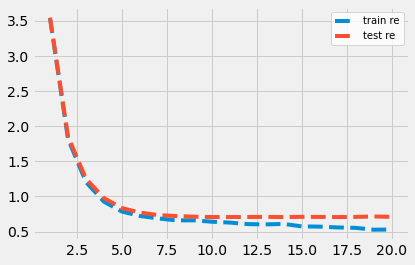

In [36]:
from matplotlib import pyplot as plt

x = np.arange(1, 21) * step_size

with plt.style.context('fivethirtyeight'):
 
    plt.plot(values, rmse_train_re, label='train re', linestyle='--')
    plt.plot(values, rmse_test_re, label='test re', ls='--')
plt.legend()
plt.show()

In [45]:
model = ExplicitFactorizationModel(loss='regression',
                                   embedding_dim = 32,  # latent dimensionality
                                   n_iter=10,  # number of epochs of training
                                   batch_size=1024,  # minibatch size
                                   l2 = 1e-9,  # strength of L2 regularization
                                   learning_rate = 1e-3,
                                   use_cuda=torch.cuda.is_available())


model.fit(train, verbose=True)
print(rmse_score(model, val))

Epoch 0: loss 15.411975238941334
Epoch 1: loss 7.082794332945788
Epoch 2: loss 2.2817861283266985
Epoch 3: loss 1.1494567533334097
Epoch 4: loss 0.7487117486971396
Epoch 5: loss 0.5836408485968908
Epoch 6: loss 0.5090760074831822
Epoch 7: loss 0.4715567482290445
Epoch 8: loss 0.449571759391714
Epoch 9: loss 0.43424551326919486
0.7099987080373674


In [ ]:
model.predict(user_ids=1)

In [ ]:
    rmse_test_re.append(rmse_score(model, val_inter))
    rmse_train_re.append(rmse_score(model, train_inter))

In [37]:
def objective(trial):

    param = {
            "embedding_dim" : trial.suggest_categorical("embedding_dim", [32, 16, 64]),
            "l2" : trial.suggest_categorical("l2", [1e-8, 1e-9, 1e-10]),            
            "learning_rate" : trial.suggest_categorical("learning_rate", [1e-3, 1e-4, 1e-2]),
        }
    
    model = ExplicitFactorizationModel(loss='regression',
                                       embedding_dim = param['embedding_dim'],  # latent dimensionality
                                       n_iter=16,  # number of epochs of training
                                       batch_size=1024,  # minibatch size
                                       l2 = param['l2'],  # strength of L2 regularization
                                       learning_rate = param['learning_rate'],
                                       use_cuda=torch.cuda.is_available())


    model.fit(train_inter, verbose=False)


    

    return rmse_score(model, val_inter)

In [41]:
# i =1
study = optuna.create_study(direction="minimize") # Create a new study.
study.optimize(objective, n_trials=25)

[I 2021-06-10 21:34:46,161] A new study created in memory with name: no-name-90c71535-99cf-46b7-94df-76f17b32c523
[I 2021-06-10 21:35:10,933] Trial 0 finished with value: 0.7087756229580199 and parameters: {'embedding_dim': 16, 'l2': 1e-10, 'learning_rate': 0.001}. Best is trial 0 with value: 0.7087756229580199.
[I 2021-06-10 21:35:40,736] Trial 1 finished with value: 0.7225405145397921 and parameters: {'embedding_dim': 64, 'l2': 1e-08, 'learning_rate': 0.001}. Best is trial 0 with value: 0.7087756229580199.
[I 2021-06-10 21:36:10,643] Trial 2 finished with value: 1.7113145238235654 and parameters: {'embedding_dim': 64, 'l2': 1e-09, 'learning_rate': 0.0001}. Best is trial 0 with value: 0.7087756229580199.
[I 2021-06-10 21:36:39,855] Trial 3 finished with value: 1.7156730069057433 and parameters: {'embedding_dim': 64, 'l2': 1e-08, 'learning_rate': 0.0001}. Best is trial 0 with value: 0.7087756229580199.
[I 2021-06-10 21:37:04,536] Trial 4 finished with value: 3.411801161257658 and param

In [38]:
# i =0
study = optuna.create_study(direction="minimize") # Create a new study.
study.optimize(objective, n_trials=25)

[I 2021-06-10 21:18:36,362] A new study created in memory with name: no-name-fa10479b-cc17-4f7c-8af6-30b9407ac36e
[I 2021-06-10 21:19:46,101] Trial 0 finished with value: 3.39475763383081 and parameters: {'embedding_dim': 16, 'l2': 1e-08, 'learning_rate': 0.0001}. Best is trial 0 with value: 3.39475763383081.
[I 2021-06-10 21:20:55,788] Trial 1 finished with value: 0.9148578444442506 and parameters: {'embedding_dim': 16, 'l2': 1e-08, 'learning_rate': 0.01}. Best is trial 1 with value: 0.9148578444442506.
[I 2021-06-10 21:22:08,055] Trial 2 finished with value: 1.7100490524879692 and parameters: {'embedding_dim': 64, 'l2': 1e-09, 'learning_rate': 0.0001}. Best is trial 1 with value: 0.9148578444442506.
[I 2021-06-10 21:23:11,910] Trial 3 finished with value: 2.6247974954518676 and parameters: {'embedding_dim': 32, 'l2': 1e-08, 'learning_rate': 0.0001}. Best is trial 1 with value: 0.9148578444442506.
[I 2021-06-10 21:24:13,294] Trial 4 finished with value: 0.9155235018213733 and paramete

In [49]:
def objective(trial):

    param = {
            "embedding_dim" : trial.suggest_categorical("embedding_dim", [32, 128, 64]),
            "l2" : trial.suggest_categorical("l2", [1e-8, 5e-8, 1e-7]),            
            "learning_rate" : trial.suggest_categorical("learning_rate", [1e-3, 5e-3, 1e-2]),
        }
    
    model = ExplicitFactorizationModel(loss='regression',
                                       embedding_dim = param['embedding_dim'],  # latent dimensionality
                                       n_iter=20,  # number of epochs of training
                                       batch_size=1024,  # minibatch size
                                       l2 = param['l2'],  # strength of L2 regularization
                                       learning_rate = param['learning_rate'],
                                       use_cuda=torch.cuda.is_available())


    model.fit(train, verbose=False)


    

    return rmse_score(model, val)

In [50]:
study = optuna.create_study(direction="minimize") # Create a new study.
study.optimize(objective, n_trials=20)

[I 2021-06-04 14:57:59,660] A new study created in memory with name: no-name-0c00bba0-4fcf-42c9-9d9d-39c950ebd374
[I 2021-06-04 14:58:06,981] Trial 0 finished with value: 1.374014160987807 and parameters: {'embedding_dim': 32, 'l2': 5e-08, 'learning_rate': 0.005}. Best is trial 0 with value: 1.374014160987807.
[I 2021-06-04 14:58:15,095] Trial 1 finished with value: 1.3471676855469734 and parameters: {'embedding_dim': 64, 'l2': 5e-08, 'learning_rate': 0.005}. Best is trial 1 with value: 1.3471676855469734.
[I 2021-06-04 14:58:23,201] Trial 2 finished with value: 1.3194021815954926 and parameters: {'embedding_dim': 64, 'l2': 1e-07, 'learning_rate': 0.01}. Best is trial 2 with value: 1.3194021815954926.
[I 2021-06-04 14:58:31,290] Trial 3 finished with value: 1.314506221052152 and parameters: {'embedding_dim': 64, 'l2': 1e-08, 'learning_rate': 0.01}. Best is trial 3 with value: 1.314506221052152.
[I 2021-06-04 14:58:38,837] Trial 4 finished with value: 1.2238909658660935 and parameters: 

In [51]:
study.best_trial.params

{'embedding_dim': 128, 'l2': 1e-07, 'learning_rate': 0.001}

In [52]:
  
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

from deepctr_torch.inputs import SparseFeat, VarLenSparseFeat, get_feature_names
from deepctr_torch.models import DeepFM


def split(x):
    key_ans = x.split('|')
    for key in key_ans:
        if key not in key2index:
            # Notice : input value 0 is a special "padding",so we do not use 0 to encode valid feature for sequence input
            key2index[key] = len(key2index) + 1
    return list(map(lambda x: key2index[x], key_ans))


if __name__ == "__main__":
    data = pd.read_csv("./movielens_sample.txt")
    sparse_features = ["movie_id", "user_id",
                       "gender", "age", "occupation", "zip", ]
    target = ['rating']

    # 1.Label Encoding for sparse features,and process sequence features
    for feat in sparse_features:
        lbe = LabelEncoder()
        data[feat] = lbe.fit_transform(data[feat])
    # preprocess the sequence feature

    key2index = {}
    genres_list = list(map(split, data['genres'].values))
    genres_length = np.array(list(map(len, genres_list)))
    max_len = max(genres_length)
    # Notice : padding=`post`
    genres_list = pad_sequences(genres_list, maxlen=max_len, padding='post', )

    # 2.count #unique features for each sparse field and generate feature config for sequence feature

    fixlen_feature_columns = [SparseFeat(feat, data[feat].nunique(), embedding_dim=4)
                              for feat in sparse_features]

    varlen_feature_columns = [VarLenSparseFeat(SparseFeat('genres', vocabulary_size=len(
        key2index) + 1, embedding_dim=4), maxlen=max_len, combiner='mean')]  # Notice : value 0 is for padding for sequence input feature

    linear_feature_columns = fixlen_feature_columns + varlen_feature_columns
    dnn_feature_columns = fixlen_feature_columns + varlen_feature_columns

    feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

    # 3.generate input data for model
    model_input = {name: data[name] for name in sparse_features}  #
    model_input["genres"] = genres_list

    # 4.Define Model,compile and train

    device = 'cpu'
    use_cuda = True
    if use_cuda and torch.cuda.is_available():
        print('cuda ready...')
        device = 'cuda:0'

    model = DeepFM(linear_feature_columns, dnn_feature_columns, task='regression', device=device)

    model.compile("adam", "mse", metrics=['mse'], )
    history = model.fit(model_input, data[target].values, batch_size=256, epochs=10, verbose=2, validation_split=0.2)